In [1]:
# Here we take care of paths.

from pathlib import Path
import os
print('Starting path:' + os.getcwd())
if os.getcwd()[-18:] == 'VESUVIUS_Challenge':
    pass
else:
    PATH = Path().resolve().parents[0]
    os.chdir(PATH)

# make sure you are in Paragraph_to_Tex folder
print('Current path:' + os.getcwd())

Starting path:/home/gregory_maruss/VESUVIUS_Challenge/jupyter notebooks
Current path:/home/gregory_maruss/VESUVIUS_Challenge


In [2]:
import monai
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from Data_Modules.MONAI_Dict_Dataset_Module import MONAI_CSV_Scrolls_Dataset
import matplotlib.patches as patches
from lit_models.UNET_TILE import UNET_TILE_lit
from monai.visualize import matshow3d
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm.auto import tqdm
import cv2
import numpy as np
import gc

DEVICE =torch.device("cuda" if torch.cuda.is_available() else "cpu")

import warnings
warnings.filterwarnings('ignore', category=UserWarning, message='TypedStorage is deprecated')

2023-05-03 17:47:26,019 - Created a temporary directory at /tmp/tmp7mlcegd4
2023-05-03 17:47:26,026 - Writing /tmp/tmp7mlcegd4/_remote_module_non_scriptable.py


In [3]:
COMPETITION_DATA_DIR_str =  "kaggle/input/vesuvius-challenge-ink-detection/"
PATCH_SIZE = 256
Z_DIM = 32


In [4]:
fragment_ids = sorted(os.listdir(COMPETITION_DATA_DIR_str + 'test'))
fragment_ids

['a', 'b']

In [5]:
class CFG:
    
    train_fragment_id=[2,3]
    val_fragment_id=[1]
    batch_size = 32
    patch_size = 256
    z_dim = Z_DIM
    stride = patch_size // 2
    #comp_dataset_path = COMPETITION_DATA_DIR
    num_workers = 8
    on_gpu = True
    test_fragment_ids = ['a','b']
    

In [21]:
lit_model = UNET_TILE_lit(
        use_wandb = False,
        z_dim = Z_DIM,
        patch_size = (256,256),
        sw_batch_size=8 ,
        eta_min = 1e-7,
        t_max = 120,
        max_epochs = 1000,
        weight_decay =  1e-6,
        learning_rate = 0.0001,
        gamma = 0.85,)


lit_model = lit_model.load_from_checkpoint('logs/EFFB3_512X2_1024_Tile_16_256patch/epoch61.ckpt', 
                                           patch_size = (256,256),
                                           use_wandb=False,
                                          sw_batch_size = 4,
                                          ).to(DEVICE)

lit_model.eval()

UNET_TILE_lit(
  (metrics): ModuleDict(
    (train_metrics): MetricCollection(
      (dice): Dice(),
      prefix=train_
    )
    (val_metrics): MetricCollection(
      (dice): Dice(),
      prefix=val_
    )
  )
  (model): UNet(
    (model): Sequential(
      (0): ResidualUnit(
        (conv): Sequential(
          (unit0): Convolution(
            (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
            (adn): ADN(
              (N): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (D): Dropout(p=0.0, inplace=False)
              (A): PReLU(num_parameters=1)
            )
          )
          (unit1): Convolution(
            (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (adn): ADN(
              (N): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (D): Dropout(p=0.0, inplace=False)
              (A):

In [7]:
def make_test_dataset(fragment_id):
    test_images = read_image(fragment_id)
    
    x1_list = list(range(0, test_images.shape[1]-CFG.patch_size+1, CFG.stride))
    y1_list = list(range(0, test_images.shape[0]-CFG.patch_size+1, CFG.stride))
    
    test_images_list = []
    xyxys = []
    for y1 in y1_list:
        for x1 in x1_list:
            y2 = y1 + CFG.patch_size
            x2 = x1 + CFG.patch_size
            
            test_images_list.append(test_images[y1:y2, x1:x2])
            xyxys.append((x1, y1, x2, y2))
    xyxys = np.stack(xyxys)
            
    test_dataset = CustomDataset(test_images_list, CFG, transform=get_transforms(data='valid', cfg=CFG))
    
    test_loader = DataLoader(test_dataset,
                          batch_size=CFG.batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=False, drop_last=False)
    
    return test_loader, xyxys


def get_transforms(data, cfg):
    return A.Compose(
        [
        A.Resize(PATCH_SIZE, PATCH_SIZE),
        A.Normalize(
            mean=[0] * Z_DIM,
            std=[1] * Z_DIM
        ),

        ToTensorV2(transpose_mask=True),
    ]
    )

def read_image(fragment_id):
    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.z_dim // 2
    end = mid + CFG.z_dim // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(COMPETITION_DATA_DIR_str + f"test/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.patch_size - image.shape[0] % CFG.patch_size)
        pad1 = (CFG.patch_size - image.shape[1] % CFG.patch_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)
    
    return images

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.xyxys)
        return len(self.images)

    def __getitem__(self, idx):
        # x1, y1, x2, y2 = self.xyxys[idx]
        image = self.images[idx]
        data = self.transform(image=image)
        image = data['image']
        return image
    
    
    
def rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    # pixels = (pixels >= thr).astype(int)
    
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

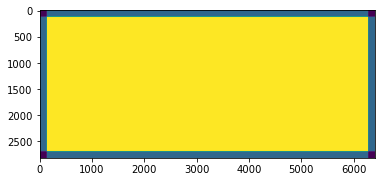

mask_count_min: 1.0


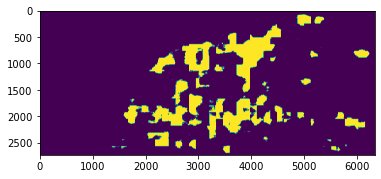

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

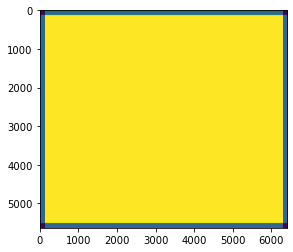

mask_count_min: 1.0


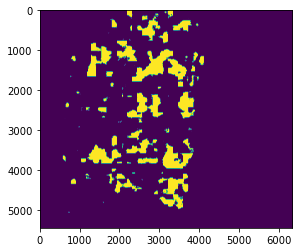

In [8]:
THRESHOLD =0.4
results = []
for fragment_id in CFG.test_fragment_ids:
    
    test_loader, xyxys = make_test_dataset(fragment_id)
    
    binary_mask = cv2.imread(COMPETITION_DATA_DIR_str + f"test/{fragment_id}/mask.png", 0)
    binary_mask = (binary_mask / 255).astype(int)
    
    ori_h = binary_mask.shape[0]
    ori_w = binary_mask.shape[1]
    # mask = mask / 255

    pad0 = (CFG.patch_size - binary_mask.shape[0] % CFG.patch_size)
    pad1 = (CFG.patch_size - binary_mask.shape[1] % CFG.patch_size)

    binary_mask = np.pad(binary_mask, [(0, pad0), (0, pad1)], constant_values=0)
    
    mask_pred = torch.zeros(binary_mask.shape).to(DEVICE)
    mask_count = torch.zeros(binary_mask.shape).to(DEVICE)

    for step, (images) in tqdm(enumerate(test_loader), total=len(test_loader)):
        images = images.to(DEVICE)
        batch_size = images.size(0)
        
        with torch.no_grad():
            y_preds = lit_model(images)
            #y_preds = y_preds.numpy()
            #print(type(y_preds))

        start_idx = step*CFG.batch_size
        end_idx = start_idx + batch_size
        #xyxys = torch.from_numpy(xyxys)
        for i, (x1, y1, x2, y2) in enumerate(xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += torch.ones((CFG.patch_size, CFG.patch_size)).to(DEVICE)
    
    plt.imshow(mask_count.to('cpu'))
    plt.show()
    
    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    
    mask_pred = mask_pred[:ori_h, :ori_w]
    binary_mask = binary_mask[:ori_h, :ori_w]
    
    mask_pred = mask_pred.to('cpu').numpy()
    mask_pred = (mask_pred >= THRESHOLD).astype(int)
    mask_pred *= binary_mask
    
    plt.imshow(mask_pred)
    plt.show()
    
    inklabels_rle = rle(mask_pred)
    
    results.append((fragment_id, inklabels_rle))
    

    del mask_pred, mask_count
    del test_loader
    
    gc.collect()
    torch.cuda.empty_cache()
    
    


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

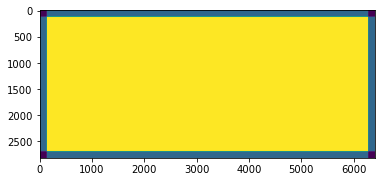

mask_count_min: 1.0


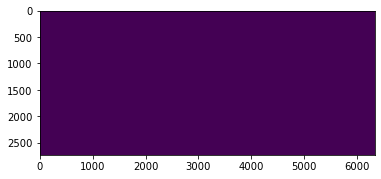

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

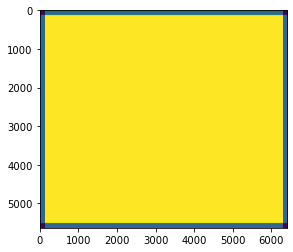

mask_count_min: 1.0


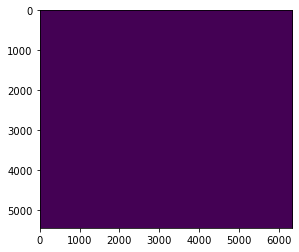

In [23]:
THRESHOLD =0.4
results = []
for fragment_id in CFG.test_fragment_ids:
    
    test_loader, xyxys = make_test_dataset(fragment_id)
    
    binary_mask = cv2.imread(COMPETITION_DATA_DIR_str + f"test/{fragment_id}/mask.png", 0)
    binary_mask = (binary_mask / 255).astype(int)
    
    ori_h = binary_mask.shape[0]
    ori_w = binary_mask.shape[1]
    # mask = mask / 255

    pad0 = (CFG.patch_size - binary_mask.shape[0] % CFG.patch_size)
    pad1 = (CFG.patch_size - binary_mask.shape[1] % CFG.patch_size)

    binary_mask = np.pad(binary_mask, [(0, pad0), (0, pad1)], constant_values=0)
    
    mask_pred = torch.zeros(binary_mask.shape).to(DEVICE)
    mask_count = torch.zeros(binary_mask.shape).to(DEVICE)

    for step, (images) in tqdm(enumerate(test_loader), total=len(test_loader)):
        images = images.to(DEVICE)
        batch_size = images.size(0)
        
        with torch.no_grad():
            y_preds = lit_model(images)
            #y_preds = y_preds.numpy()
            #print(type(y_preds))

        start_idx = step*CFG.batch_size
        end_idx = start_idx + batch_size
        #xyxys = torch.from_numpy(xyxys)
        for i, (x1, y1, x2, y2) in enumerate(xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += torch.ones((CFG.patch_size, CFG.patch_size)).to(DEVICE)
    
    plt.imshow(mask_count.to('cpu'))
    plt.show()
    
    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    
    mask_pred = mask_pred[:ori_h, :ori_w]
    binary_mask = binary_mask[:ori_h, :ori_w]
    
    mask_pred = mask_pred.to('cpu').numpy()
    mask_pred = (mask_pred >= THRESHOLD).astype(int)
    mask_pred *= binary_mask
    
    plt.imshow(mask_pred)
    plt.show()
    
    inklabels_rle = rle(mask_pred)
    
    results.append((fragment_id, inklabels_rle))
    

    del mask_pred, mask_count
    del test_loader
    
    gc.collect()
    torch.cuda.empty_cache()
    
    


from monai.inferers import sliding_window_inference

predicitons = []
for fragment_id in CFG.test_fragment_ids:
    
    test_loader, xyxys = make_test_dataset(fragment_id)
    
    binary_mask = cv2.imread(COMPETITION_DATA_DIR_str + f"test/{fragment_id}/mask.png", 0)
    for images in test_loader:
        h, w = images.shape[2], images.shape[3]
        h_mod = h % 512
        w_mod = w % 512
        h -= h_mod
        w -= w_mod
        lit_model.eval()
        with torch.no_grad():
            outputs = sliding_window_inference(inputs=images,
                                            roi_size=(1024, 4096),  
                                            sw_batch_size=4,
                                            predictor=lit_model,
                                            overlap=0.01,
                                            mode='gaussian',
                                                progress=True,
                                               sw_device='cuda',
                                               
                                              )
            predicitons.append(outputs)

In [9]:
test_df = pd.read_csv(TEST_DOWNSAMPLED_DATA_CSV_PATH)


NameError: name 'pd' is not defined

THRESHOLD = .5
inklabels_rle = []
binary_mask_a = cv2.imread(COMPETITION_DATA_DIR_str + f"test/a/mask.png", 0)
binary_mask_a = (binary_mask_a / 255).astype(int)
binary_mask_b = cv2.imread(COMPETITION_DATA_DIR_str + f"test/b/mask.png", 0)
binary_mask_b = (binary_mask_b / 255).astype(int)
prediction_masked_a = predictions[0]*binary_mask_a
prediction_masked_b = predictions[1]*binary_mask_b

prediction_masked_a = (prediction_masked_a >= THRESHOLD).astype(int)
rediction_masked_b = (prediction_masked_b >= THRESHOLD).astype(int)
plt.imshow(mask_pred)
plt.show()

inklabels_rle = rle(mask_pred)
    


submission_df["Predicted"] = predictions_rle
    
submission_df.to_csv("logs/submission.csv", index=False)

submission_df